# Setup: Importing Libraries
In this cell, we import the necessary libraries for model training and tokenization.
We use `torch` for handling the neural network and `sklearn` for splitting the dataset.

In [82]:
!pip install torch matplotlib datasets scikit-learn kaggle pandas numpy pillow

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


# Load Dataset
This section loads the dataset, which consists of images of cats and dogs. The dataset is used for training and testing the neural network.

In [84]:
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"tnillion" ,
'key':"f2d2d14da529d2ce6873c99bbe59b5c2"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [85]:
# ds = load_dataset("antareepdey/Hotdog-or-not-a-hotdog")
ds = './hotdog_data'


In [86]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download the dataset
# Replace with your actual Kaggle dataset
if not os.path.exists('./hotdog_data'):
    api.dataset_download_files('dansbecker/hot-dog-not-hot-dog', path='./hotdog_data', unzip=True)


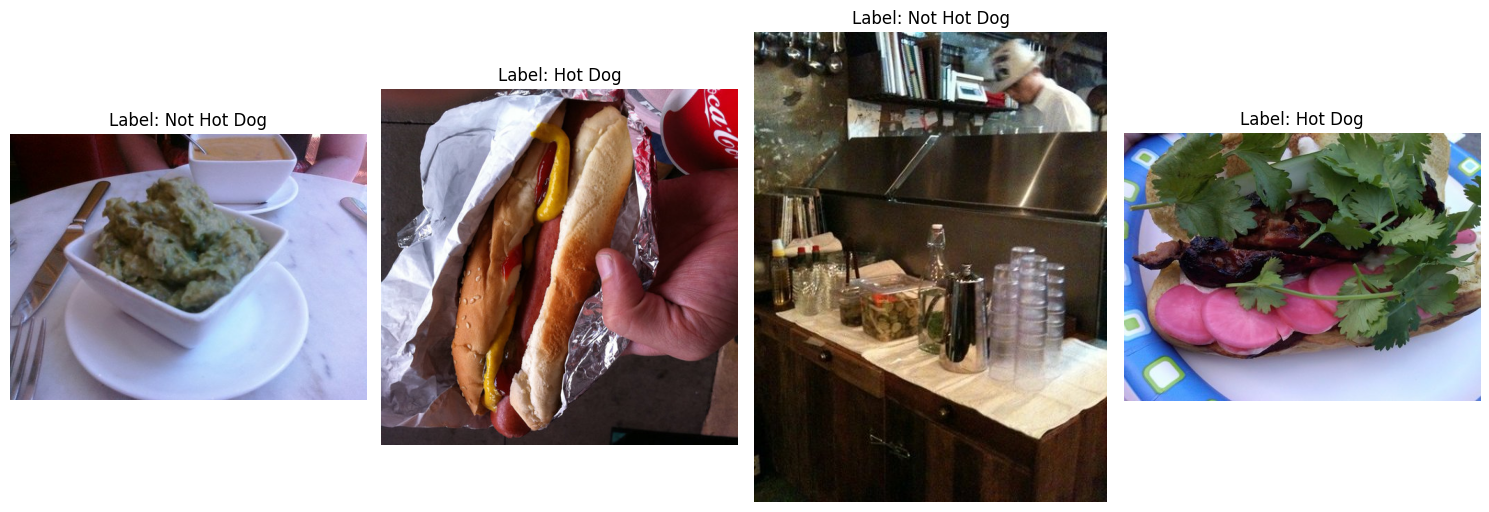

In [87]:
# Plot images from the dataset
# Old CODE
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_images(dataset, num_images=4):
#     """Plots a specified number of images from the dataset."""
#     fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
#     for i in range(num_images):
#         image = dataset['test'][i]['image']
#         label = dataset['test'][i]['label']


#         axs[i].imshow(image)
#         axs[i].axis('off')
#         axs[i].set_title(f"Label: {'Hotdog' if label == 0 else 'Not Hotdog'}")

#     plt.tight_layout()
#     plt.show()


# plot_images(ds)

import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_images(dataset_path, num_images=4):
    """Plots a specified number of images from the test set of the dataset."""
    hotdog_path = os.path.join(dataset_path, 'test', 'hot_dog')
    not_hotdog_path = os.path.join(dataset_path, 'test', 'not_hot_dog')

    hotdog_images = [f for f in os.listdir(hotdog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    not_hotdog_images = [f for f in os.listdir(not_hotdog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    axs = axs if num_images > 1 else [axs]

    for i in range(num_images):
        # Randomly choose between hotdog and not hotdog
        if random.choice([True, False]):
            img_path = os.path.join(hotdog_path, random.choice(hotdog_images))
            label = 'Hot Dog'
        else:
            img_path = os.path.join(not_hotdog_path, random.choice(not_hotdog_images))
            label = 'Not Hot Dog'

        # Open and display the image
        image = Image.open(img_path)
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

# Assuming 'ds' is the path to your downloaded dataset
plot_images(ds)

# Prepare the Dataset
In this step, we prepare the dataset by applying transformations such as resizing the images, converting them to grayscale, and normalizing the pixel values. This ensures that the input data is standardized for the model.

In [103]:
# import torch
# from torch.utils.data import DataLoader
# from torchvision import transforms
# from PIL import Image

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((28, 28)),
#     transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
#     transforms.ToTensor(),  # Convert image to Tensor
#     transforms.Normalize((0.5,), (1.0,))
# ])

# # Apply transformation to the dataset
# def transform_dataset(example):
#     # Apply the transform on the 'image' field
#     image = example['image']
#     image = transform(image)
#     example['image'] = image
#     return example

# # Apply transform to the dataset
# ds = ds.with_format("torch")
# ds = ds.map(transform_dataset)

# ds['test'] = ds['test'].shuffle(seed=42)
# ds = ds['test'].train_test_split(test_size=0.1)

# train_loader = DataLoader(ds['test'], batch_size=32, shuffle=True)
# test_loader = DataLoader(ds['test'], batch_size=32, shuffle=True)

# # train_loader = torch.utils.data.DataLoader([(x, y) for x,y in zip(ds['train']['image'], ds['train']['labels'])], batch_size=32)
# # test_loader = torch.utils.data.DataLoader([(x, y) for x,y in zip(ds['test']['image'], ds['test']['labels'])], batch_size=32)

# print(f"Number of training samples: {len(ds['train'])}")
# print(f"Number of test samples: {len(ds['test'])}")


import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class HotdogDataset(Dataset):
    def __init__(self, root_dir, split='test', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['hot_dog', 'not_hot_dog']
        self.images = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'label': label}

# Custom transform to apply Sobel filter
class SobelFilter:
    def __call__(self, img_tensor):
        # Sobel kernels for x and y direction
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Apply the Sobel filter to the image
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
        sobel_x_filtered = F.conv2d(img_tensor, sobel_x, padding=1)
        sobel_y_filtered = F.conv2d(img_tensor, sobel_y, padding=1)

        # Combine the two filtered images (gradient magnitude)
        sobel_filtered = torch.sqrt(sobel_x_filtered**2 + sobel_y_filtered**2)

        return sobel_filtered.squeeze(0)  # Remove batch dimension

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    SobelFilter(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets
ds = HotdogDataset(root_dir='./hotdog_data', split='test', transform=transform)

# Split the test set into train and test
train_size = int(0.9 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Verify the data
for batch in train_loader:
    images, labels = batch['image'], batch['label']
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Number of training samples: 450
Number of test samples: 50
Batch shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])


Training images:


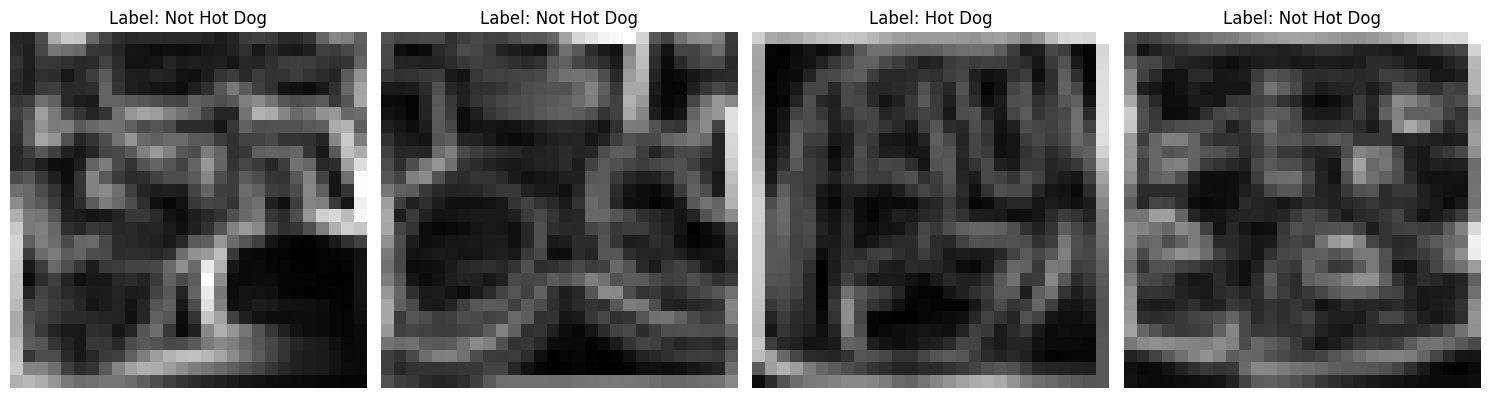

Test images:


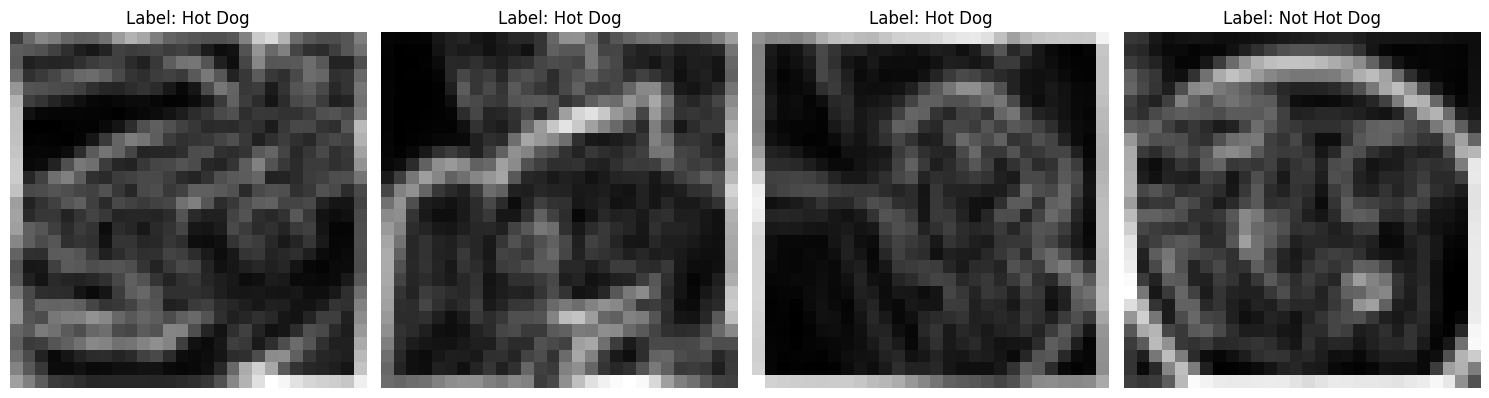

In [104]:
# # plot the images after preprocessing

# import matplotlib.pyplot as plt
# def plot_transformed_images(dataset, split='train', num_images=4):
#   """Plots a specified number of images from the transformed dataset."""
#   fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

#   for i in range(num_images):
#         # Get an item from the dataset
#         item = dataset[split][i]
#         image = item['image']
#         label = item['label']

#         # Convert tensor to numpy and reshape for display
#         image = image.squeeze().numpy()

#         axs[i].imshow(image, cmap='gray')  # Display grayscale image
#         axs[i].axis('off')
#         axs[i].set_title(f"Label: {'Hotdog' if label == 0 else 'Not Hotdog'}")

#   plt.tight_layout()

#   plt.show()

# print("Training images:")
# plot_transformed_images(ds, split='train')

# print("Test images:")
# plot_transformed_images(ds, split='test')

import matplotlib.pyplot as plt
import torch

def plot_transformed_images(dataset, num_images=4):
    """Plots a specified number of images from the transformed dataset."""
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    # Get a batch of images
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    batch = next(iter(dataloader))

    images = batch['image']
    labels = batch['label']

    for i in range(num_images):
        image = images[i].squeeze().numpy()
        label = labels[i].item()

        axs[i].imshow(image, cmap='gray')  # Display grayscale image
        axs[i].axis('off')
        axs[i].set_title(f"Label: {'Hot Dog' if label == 0 else 'Not Hot Dog'}")

    plt.tight_layout()
    plt.show()

# Assuming we've already created train_dataset and test_dataset as before:
# train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

print("Training images:")
plot_transformed_images(train_dataset)

print("Test images:")
plot_transformed_images(test_dataset)

# Define the LeNet5 Model
This section defines the LeNet5 model architecture. It includes convolutional and pooling layers for feature extraction, followed by fully connected layers for classification.

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [91]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.flattener = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))


network = LeNet5()
network.to(device)
optimizer = optim.Adam(network.parameters(), lr=1e-3)


# Instantiate a torch loss function
loss_fn = nn.CrossEntropyLoss()

## Add Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)


# Training the LeNet5 Model
In this section, we implement the training loop for the LeNet5 model. The model is trained over multiple epochs where:

1. **Forward Pass**: The input images are passed through the model to make predictions.
2. **Loss Calculation**: The predicted outputs are compared with the true labels using a loss function (e.g., CrossEntropy Loss).
3. **Backward Pass**: The gradients are computed through backpropagation to adjust the weights of the model.
4. **Optimization Step**: An optimizer (e.g., SGD or Adam) updates the weights of the model based on the computed gradients to minimize the loss.
This process is repeated over several batches of the training dataset to improve the model's performance.

In [92]:

# label_encoder = {'hotdog': 1, 'not_hotdog': 0}

# def train(epoch):
#     network.train()
#     for batch_idx, batch in enumerate(train_loader):
#         data = batch['image'].to(device)
#         target = torch.tensor([label_encoder[label] for label in batch['label']], dtype=torch.long).to(device)
#         optimizer.zero_grad()
#         logits = network(data)
#         loss = loss_fn(logits, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
#     network.eval()
#     train_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for batch in train_loader:
#             data = batch['image'].to(device)
#             target = torch.tensor([label_encoder[label] for label in batch['label']], dtype=torch.long).to(device)

#             logits = network(data)
#             train_loss += loss_fn(logits, target).item() * data.size(0)
#             pred = logits.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
#     train_loss /= len(train_loader.dataset)
#     print('\nTraining set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#     train_loss, correct, len(train_loader.dataset),
#     100. * correct / len(train_loader.dataset)))
#       #torch.save(network.state_dict(), '/results/model.pth')
#       #torch.save(optimizer.state_dict(), '/results/optimizer.pth')


# Model Evaluation and Inference
After the model is trained, we evaluate its performance on a test set. This involves:

1. **Switch to Evaluation Mode**: The model is set to evaluation mode, disabling any layers that behave differently during training (like Dropout or BatchNorm).
2. **Forward Pass for Inference**: The test data is passed through the trained model to generate predictions.
3. **Accuracy Calculation**: The predictions are compared to the actual labels to calculate accuracy, giving insight into how well the model generalizes to unseen data.

In [93]:
# def test():
#   network.eval()
#   test_loss = 0
#   correct = 0
#   with torch.no_grad():
#     for data, target in test_loader:
#       data, target = data.to(device), target.to(device)
#       output = network(data)
#       test_loss += F.nll_loss(output, target, size_average=False).item()
#       pred = output.data.max(1, keepdim=True)[1]
#       correct += pred.eq(target.data.view_as(pred)).sum()
#   test_loss /= len(test_loader.dataset)
#   print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#     test_loss, correct, len(test_loader.dataset),
#     100. * correct / len(test_loader.dataset)))


In [94]:
#OLD / CURRENT CODE

import torch
import torch.nn.functional as F

def train(epoch):
    network.train()
    for batch_idx, batch in enumerate(train_loader):
        data = batch['image'].to(device)
        target = batch['label'].to(device)

        optimizer.zero_grad()
        logits = network(data)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in train_loader:
            data = batch['image'].to(device)
            target = batch['label'].to(device)

            logits = network(data)
            train_loss += loss_fn(logits, target).item() * data.size(0)
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTraining set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            data = batch['image'].to(device)
            target = batch['label'].to(device)

            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

# Usage remains the same
N_EPOCHS = 20
for epoch in range(1, N_EPOCHS + 1):
    train(epoch)
    test_loss = test()
    scheduler.step(test_loss)


Train Epoch: 1 [0/450 (0%)]	Loss: 2.324231

Training set: Avg. loss: 0.8737, Accuracy: 222/450 (49%)


Test set: Avg. loss: -3.8285, Accuracy: 28/50 (56%)

Train Epoch: 2 [0/450 (0%)]	Loss: 0.911606

Training set: Avg. loss: 0.7464, Accuracy: 222/450 (49%)


Test set: Avg. loss: -9.2346, Accuracy: 28/50 (56%)

Train Epoch: 3 [0/450 (0%)]	Loss: 0.794889

Training set: Avg. loss: 0.6980, Accuracy: 222/450 (49%)


Test set: Avg. loss: -7.2591, Accuracy: 28/50 (56%)

Train Epoch: 4 [0/450 (0%)]	Loss: 0.694764

Training set: Avg. loss: 0.6953, Accuracy: 222/450 (49%)


Test set: Avg. loss: -5.9010, Accuracy: 28/50 (56%)

Train Epoch: 5 [0/450 (0%)]	Loss: 0.723390

Training set: Avg. loss: 0.6817, Accuracy: 265/450 (59%)


Test set: Avg. loss: -5.5918, Accuracy: 22/50 (44%)

Train Epoch: 6 [0/450 (0%)]	Loss: 0.678060

Training set: Avg. loss: 0.6632, Accuracy: 265/450 (59%)


Test set: Avg. loss: -6.5337, Accuracy: 30/50 (60%)

Train Epoch: 7 [0/450 (0%)]	Loss: 0.703034

Training set: Avg. l

In [95]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torchvision import transforms
# from torch.utils.data import DataLoader
# from torchvision.datasets import ImageFolder

# # Define data transforms
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Load datasets
# train_dataset = ImageFolder(root='hotdog_data/train', transform=train_transform)
# test_dataset = ImageFolder(root='hotdog_data/test', transform=test_transform)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# # Define the network
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.conv3 = nn.Conv2d(64, 64, 3, 1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.fc1 = nn.Linear(64 * 26 * 26, 128)
#         self.fc2 = nn.Linear(128, 2)  # 2 classes: hotdog or not hotdog

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

# network = Net().to(device)
# optimizer = optim.Adam(network.parameters(), lr=0.001)
# loss_fn = nn.NLLLoss()

# def train(epoch):
#     network.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)

#         optimizer.zero_grad()
#         logits = network(data)
#         loss = loss_fn(logits, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

#     network.eval()
#     train_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)

#             logits = network(data)
#             train_loss += loss_fn(logits, target).item() * data.size(0)
#             pred = logits.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     train_loss /= len(train_loader.dataset)
#     print('\nTraining set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss, correct, len(train_loader.dataset),
#         100. * correct / len(train_loader.dataset)))

# def test():
#     network.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)

#             output = network(data)
#             test_loss += loss_fn(output, target).item() * data.size(0)
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
#     print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
#     return test_loss


# # Usage
# N_EPOCHS = 10
# for epoch in range(1, N_EPOCHS + 1):
#     train(epoch)
#     test_loss = test()
#     scheduler.step(test_loss)



In [96]:
torch.save(network.to('cpu').state_dict(), "./hotdog_or_not_lenet5.pth")